In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-06 12:22:50.365446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from importlib import reload

In [5]:
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [6]:
L_vars = 19

In [7]:
filename_neg_storm = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg*indx20*indy45*.npy"))

filename_pos_storm1 = glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*indx20*indy45*.npy")
filename_pos_storm2 = glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*indx20*indy46*.npy")
filename_pos_storm3 = glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*indx19*indy45*.npy")
filename_pos_storm4 = glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*indx19*indy46*.npy")

filename_pos_storm = sorted(filename_pos_storm1+filename_pos_storm2+filename_pos_storm3+filename_pos_storm4)

In [8]:
filename_pos_storm_valid = filename_pos_storm[27:55]
filename_pos_storm_train = list(set(filename_pos_storm) - set(filename_pos_storm[27:55]))

In [9]:
filename_neg_storm_valid = filename_neg_storm[350:550]
filename_neg_storm_train = list(set(filename_neg_storm) - set(filename_neg_storm[350:550]))

In [10]:
L_valid_pos = len(filename_pos_storm_valid)
L_valid_neg = len(filename_neg_storm_valid)

In [11]:
L_var = 19

N_valid = L_valid_pos+L_valid_neg

TEST_input = np.empty((N_valid, 128, 128, L_var))
TEST_target = np.ones(N_valid)
TEST_target[L_valid_pos:] = 0

for i, name in enumerate(filename_pos_storm_valid+filename_neg_storm_valid):
    TEST_input[i, ...] = np.load(name)

**ConvNext**

In [12]:
MODEL_CONFIGS = {
    "tiny": {
        "depths": [3, 3, 9, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "small": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "base": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [128, 256, 512, 1024],
    },
    "large": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [192, 384, 768, 1536],
    },
    "xlarge": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [256, 512, 1024, 2048],
    },
}

In [13]:
model = ck.ConvNeXt(
        depths=MODEL_CONFIGS["small"]["depths"],
        projection_dims=MODEL_CONFIGS["small"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        model_name='test',
        input_shape=(128, 128, 19),
        pooling='max',
        classes=1,
    )#0.5 #0.1 #1e-6

2022-09-06 12:23:13.167622: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-06 12:23:13.169474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-06 12:23:13.212356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-06 12:23:13.212395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-06 12:23:13.263841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-06 12:23:13.263896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [14]:
def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI

    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    print('{} {} {}'.format(CSI, AUC, freq))
    metric = CSI_metric

    return metric

In [15]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [16]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'CONVNEXT_S'

model_name = '{}_pp19_tune2'.format(key)
model_path = temp_dir+model_name

W_old = k_utils.dummy_loader(temp_dir+'CONVNEXT_S_pp19_tune')
model.set_weights(W_old)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=1e-6))

In [17]:
# X_batch_sparse = np.empty((batch_size, 128, 128, L_sparse))*np.nan
# X_batch_dense = np.empty((batch_size, 128, 128, L_dense))*np.nan
X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [18]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2022-09-06 12:23:24.071386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-06 12:23:24.071907: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2022-09-06 12:23:24.117016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-06 12:23:25.220070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [19]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred, thres=0.5)
print("Initial record: {}".format(record))

0.28846153846153844 0.71875 1.3928571428571428
Initial record: 0.7115384615384616


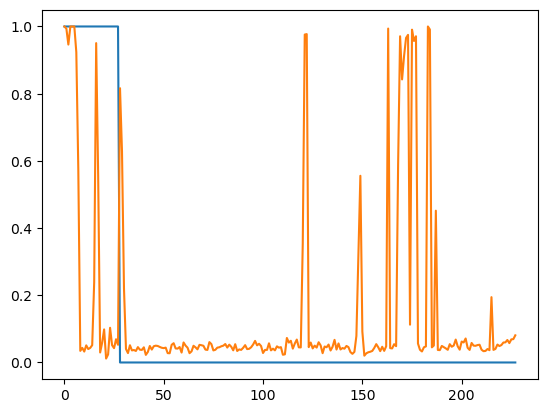

In [23]:
plt.plot(TEST_target)
plt.plot(Y_pred)

In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(1, 30))
N_storm = 100 - N_aug

L_storm = len(filename_neg_storm_train)
L_aug = len(filename_pos_storm_train)

for i in range(epochs):
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_storm_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug #file_pick_calm + 
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            #for c, v in enumerate(ind_pick_from_batch):
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.9, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.1)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    
    # plt.figure()
    # plt.plot(TEST_target)
    # plt.plot(Y_pred)
    
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.23529411764705882 0.7052678571428571 1.25
Validation loss 0.7647058823529411 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.25 0.6891071428571429 1.1428571428571428
Validation loss 0.75 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.20833333333333334 0.6798214285714286 1.0714285714285714
Validation loss 0.7916666666666666 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.21739130434782608 0.6694642857142857 1.0
Validation loss 0.782608695652174 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.2222222222222222 0.6525 0.9642857142857143
Validation loss 0.7777777777777778 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.2222222222222222 0.6535714285714286 0.9642857142857143
Validation loss 0.7777777777777778 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.2222222222222222 0.6551785714285714 0.9642857142857143
Validation loss 0.7777777777777778 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.2222222222222222 0.65625 0.9642857142857143
Validation loss 0.7777777777777778 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.2222222222222222 0.6514285714285715 0.9642857142857143
Validation loss 0.7777777777777778 NOT improved



KeyboardInterrupt

